In [1]:
import numpy as np
import pandas as pd 
import os
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate,multiply, LocallyConnected2D, Lambda)
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras import backend as K
import keras
from keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB7
import skimage.io
from skimage.transform import resize

from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy, categorical_crossentropy
#from keras.applications.resnet50 import preprocess_input
from keras.applications.densenet import DenseNet121,DenseNet169,preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score, cohen_kappa_score

import keras.callbacks as callbacks
from keras.callbacks import Callback
get_ipython().run_line_magic('config', 'InlineBackend.figure_format="svg"')
get_ipython().run_line_magic('matplotlib', 'inline')

import warnings
warnings.filterwarnings("ignore")
SIZE = 224
NUM_CLASSES = 2
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Embedding, LSTM, Dropout, Dense, Input, Bidirectional, Flatten, Conv2D, MaxPooling2D, concatenate, Conv1D, MaxPooling1D
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, concatenate
from keras.models import Model



In [2]:
from sklearn.model_selection import train_test_split


In [3]:
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler


def get_num_input():
    df = pd.read_csv('/DATA/akanksha_2021cs39/audiodataset.csv')
    df = df.drop(['filename'],axis=1)
    columns = list(df.columns)
    features = columns[:-1]
    cls_name = columns[-1]
    X = np.zeros((len(df), len(features)))
    Y = list()
    for i, row in df.iterrows():
        X[i] = row[features]                    
        Y.append(row[cls_name])

    return (X, Y)
X_num, Y = get_num_input()
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
X_audio_train, X_audio_test, y_audio_train, y_audio_test = train_test_split( X_num, Y, test_size=0.2,random_state=42)
#Scaling the Feature columns
#scaler = StandardScaler()
#X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float)

#def get_img_input():
    #df = pd.read_csv('/DATA/akanksha_2021cs39/visualdata.csv')
    #X_img = np.zeros((len(df), 224, 224)) # change as per image size
    #Y = list()
    #for i, row in df.iterrows():
        #X_img[i] = np.array(Image.open(row['X_img']))
        #Y.append(row['class'])

    #return (X_img, Y)
    
#X_img, Y_img = get_img_input() # use one of the Ys
# X feature normalization, convert Y to one-hot representation

In [4]:
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
def get_img_input():
    df = pd.read_csv('/DATA/akanksha_2021cs39/visualdata.csv')
    columns = list(df.columns)
    features = columns[:-1]
    cls_name = columns[-1]
    X = np.zeros((len(df), len(features)))
    Y = list()
    for i, row in df.iterrows():
        X[i] = row[features]                    
        Y.append(row[cls_name])

    return (X, Y)
X_img, Y_img = get_img_input()
encoder = LabelEncoder()
Y_img = encoder.fit_transform(Y_img)
X_img_train, X_img_test, y_img_train, y_img_test = train_test_split( X_img, Y_img, test_size=0.2,random_state=42)

In [5]:
y_train=y_img_train
y_test=y_img_test

In [6]:
print(X_audio_train.shape)
print(X_img_train.shape)
print(X_audio_test.shape)
print(X_img_test.shape)
print(y_audio_train.shape)
print(y_img_train.shape)
print(y_audio_test.shape)
print(y_img_test.shape)

(403, 133)
(403, 50177)
(101, 133)
(101, 50177)
(403,)
(403,)
(101,)
(101,)


In [7]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, concatenate
from keras.models import Model
import numpy as np
from keras import regularizers
from keras.layers import Dropout 
def compile_model():
    img_input = Input(shape=(50177,)) 
    ## branch 1 with image input
    x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(img_input)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    out_a = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    
    #x = MaxPooling2D((2, 2))(x)
    #x = Flatten()(x)
    #out_a = Dense(64)(x)

    num_input = Input(shape=(133,))        ## branch 2 with numerical input
    x1 = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(num_input)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)
    x1 = Dropout(0.3)(x1)
    out_b = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)

    concatenated = concatenate([out_a, out_b])    ## concatenate the two branches
    out = Dense(1, activation='sigmoid')(concatenated)
    model = Model([img_input, num_input], out)
    adam = Adam(lr=0.001, decay=1e-5)
    print(model.summary())
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])
    return model
    
    
    

### Just for sanity check

#print(model.predict(X))

In [8]:
    #img_input = Input(shape=(50177,)) 
    ## branch 1 with image input
    #x = Dense(8, activation='relu')(img_input)
    #out_a = Dense(16, activation='relu')(x)
    #x = MaxPooling2D((2, 2))(x)
    #x = Flatten()(x)
    #out_a = Dense(64)(x)

    #num_input = Input(shape=(133,))        ## branch 2 with numerical input
    #x1 = Dense(8, activation='relu')(num_input)
    #out_b = Dense(16, activation='relu')(x1)

    #concatenated = concatenate([out_a, out_b])    ## concatenate the two branches
    #out = Dense(1, activation='sigmoid')(concatenated)
    #model = Model([img_input, num_input], out)
    #adam = Adam(lr=0.001, decay=1e-5)
    #print(model.summary())
    #model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])
    #return model

In [9]:
model = compile_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50177)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 133)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         51382272    input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 1024)         137216      input_2[0][0]                    
______________________________________________________________________________________________

In [10]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
history1=model.fit([X_img_train, X_audio_train], y_train, batch_size=256, epochs=1000,
                            validation_data=([X_img_test, X_audio_test], y_test), callbacks=[es])

Epoch 1/1000
2/2 [==============================] - 4s 633ms/step - loss: 879.9532 - accuracy: 0.4541 - val_loss: 87.7651 - val_accuracy: 0.4158
Epoch 2/1000
2/2 [==============================] - 1s 386ms/step - loss: 917.3389 - accuracy: 0.4888 - val_loss: 151.2387 - val_accuracy: 0.4455
Epoch 3/1000
2/2 [==============================] - 1s 362ms/step - loss: 804.2283 - accuracy: 0.5062 - val_loss: 279.7682 - val_accuracy: 0.5545
Epoch 4/1000
2/2 [==============================] - 1s 388ms/step - loss: 657.3936 - accuracy: 0.5211 - val_loss: 344.8997 - val_accuracy: 0.5545
Epoch 5/1000
2/2 [==============================] - 1s 391ms/step - loss: 551.8245 - accuracy: 0.5558 - val_loss: 266.5764 - val_accuracy: 0.5545
Epoch 6/1000
2/2 [==============================] - 1s 387ms/step - loss: 454.2818 - accuracy: 0.5409 - val_loss: 271.0093 - val_accuracy: 0.5545
Epoch 7/1000
2/2 [==============================] - 1s 402ms/step - loss: 432.9716 - accuracy: 0.5831 - val_loss: 213.1762 - 

2/2 [==============================] - 1s 375ms/step - loss: 48.5306 - accuracy: 0.8238 - val_loss: 41.8856 - val_accuracy: 0.9010
Epoch 58/1000
2/2 [==============================] - 1s 399ms/step - loss: 49.6229 - accuracy: 0.8337 - val_loss: 41.9778 - val_accuracy: 0.8020
Epoch 59/1000
2/2 [==============================] - 1s 396ms/step - loss: 47.2854 - accuracy: 0.8263 - val_loss: 41.9493 - val_accuracy: 0.7327
Epoch 60/1000
2/2 [==============================] - 1s 415ms/step - loss: 47.3377 - accuracy: 0.8412 - val_loss: 41.5966 - val_accuracy: 0.7921
Epoch 61/1000
2/2 [==============================] - 1s 377ms/step - loss: 47.2048 - accuracy: 0.8387 - val_loss: 41.3512 - val_accuracy: 0.8416
Epoch 62/1000
2/2 [==============================] - 1s 421ms/step - loss: 47.7109 - accuracy: 0.7965 - val_loss: 41.1589 - val_accuracy: 0.8119
Epoch 63/1000
2/2 [==============================] - 1s 411ms/step - loss: 47.4021 - accuracy: 0.8213 - val_loss: 41.0508 - val_accuracy: 0.7723

2/2 [==============================] - 1s 357ms/step - loss: 34.0132 - accuracy: 0.8288 - val_loss: 33.1591 - val_accuracy: 0.9208
Epoch 114/1000
2/2 [==============================] - 1s 352ms/step - loss: 34.0618 - accuracy: 0.8189 - val_loss: 33.0617 - val_accuracy: 0.9109
Epoch 115/1000
2/2 [==============================] - 1s 343ms/step - loss: 33.8426 - accuracy: 0.8313 - val_loss: 32.9326 - val_accuracy: 0.9208
Epoch 116/1000
2/2 [==============================] - 1s 371ms/step - loss: 33.6213 - accuracy: 0.8486 - val_loss: 32.8822 - val_accuracy: 0.9208
Epoch 117/1000
2/2 [==============================] - 1s 368ms/step - loss: 33.9402 - accuracy: 0.8238 - val_loss: 32.7526 - val_accuracy: 0.9208
Epoch 118/1000
2/2 [==============================] - 1s 355ms/step - loss: 33.3051 - accuracy: 0.8437 - val_loss: 32.6632 - val_accuracy: 0.9208
Epoch 119/1000
2/2 [==============================] - 1s 347ms/step - loss: 33.1176 - accuracy: 0.8486 - val_loss: 32.5631 - val_accuracy: 

2/2 [==============================] - 1s 363ms/step - loss: 27.3838 - accuracy: 0.8809 - val_loss: 27.2759 - val_accuracy: 0.9208
Epoch 170/1000
2/2 [==============================] - 1s 361ms/step - loss: 27.3149 - accuracy: 0.8834 - val_loss: 27.1662 - val_accuracy: 0.9109
Epoch 171/1000
2/2 [==============================] - 1s 336ms/step - loss: 27.3793 - accuracy: 0.8834 - val_loss: 27.1098 - val_accuracy: 0.9208
Epoch 172/1000
2/2 [==============================] - 1s 365ms/step - loss: 27.1100 - accuracy: 0.8734 - val_loss: 27.0265 - val_accuracy: 0.9208
Epoch 173/1000
2/2 [==============================] - 1s 377ms/step - loss: 27.0324 - accuracy: 0.8809 - val_loss: 26.9411 - val_accuracy: 0.9208
Epoch 174/1000
2/2 [==============================] - 1s 381ms/step - loss: 26.9514 - accuracy: 0.8784 - val_loss: 26.8507 - val_accuracy: 0.9208
Epoch 175/1000
2/2 [==============================] - 1s 349ms/step - loss: 26.8525 - accuracy: 0.8908 - val_loss: 26.7184 - val_accuracy: 

2/2 [==============================] - 1s 390ms/step - loss: 23.0784 - accuracy: 0.8561 - val_loss: 22.9544 - val_accuracy: 0.9208
Epoch 226/1000
2/2 [==============================] - 1s 332ms/step - loss: 22.9612 - accuracy: 0.8859 - val_loss: 22.8772 - val_accuracy: 0.9208
Epoch 227/1000
2/2 [==============================] - 1s 406ms/step - loss: 22.9228 - accuracy: 0.8635 - val_loss: 22.8017 - val_accuracy: 0.9208
Epoch 228/1000
2/2 [==============================] - 1s 362ms/step - loss: 22.8213 - accuracy: 0.8883 - val_loss: 22.7256 - val_accuracy: 0.9208
Epoch 229/1000
2/2 [==============================] - 1s 347ms/step - loss: 22.7700 - accuracy: 0.8859 - val_loss: 22.6553 - val_accuracy: 0.9208
Epoch 230/1000
2/2 [==============================] - 1s 334ms/step - loss: 22.6936 - accuracy: 0.8933 - val_loss: 22.5886 - val_accuracy: 0.9208
Epoch 231/1000
2/2 [==============================] - 1s 382ms/step - loss: 22.6520 - accuracy: 0.8809 - val_loss: 22.5244 - val_accuracy: 

2/2 [==============================] - 1s 363ms/step - loss: 20.3642 - accuracy: 0.8685 - val_loss: 19.8472 - val_accuracy: 0.9208
Epoch 282/1000
2/2 [==============================] - 1s 358ms/step - loss: 19.8518 - accuracy: 0.9007 - val_loss: 19.7694 - val_accuracy: 0.9208
Epoch 283/1000
2/2 [==============================] - 1s 335ms/step - loss: 19.8324 - accuracy: 0.8784 - val_loss: 19.7504 - val_accuracy: 0.9208
Epoch 284/1000
2/2 [==============================] - 1s 359ms/step - loss: 19.8216 - accuracy: 0.8759 - val_loss: 19.7012 - val_accuracy: 0.9208
Epoch 285/1000
2/2 [==============================] - 1s 357ms/step - loss: 19.7238 - accuracy: 0.8859 - val_loss: 19.6297 - val_accuracy: 0.9208
Epoch 286/1000
2/2 [==============================] - 1s 347ms/step - loss: 19.7150 - accuracy: 0.8859 - val_loss: 19.5968 - val_accuracy: 0.9208
Epoch 287/1000
2/2 [==============================] - 1s 376ms/step - loss: 19.6072 - accuracy: 0.8983 - val_loss: 19.5497 - val_accuracy: 

2/2 [==============================] - 1s 348ms/step - loss: 17.4715 - accuracy: 0.8908 - val_loss: 17.3807 - val_accuracy: 0.9208
Epoch 338/1000
2/2 [==============================] - 1s 348ms/step - loss: 17.4154 - accuracy: 0.8908 - val_loss: 17.3283 - val_accuracy: 0.9208
Epoch 339/1000
2/2 [==============================] - 1s 387ms/step - loss: 17.3844 - accuracy: 0.8933 - val_loss: 17.2793 - val_accuracy: 0.9208
Epoch 340/1000
2/2 [==============================] - 1s 357ms/step - loss: 17.3118 - accuracy: 0.8908 - val_loss: 17.2311 - val_accuracy: 0.9208
Epoch 341/1000
2/2 [==============================] - 1s 345ms/step - loss: 17.2584 - accuracy: 0.9007 - val_loss: 17.1848 - val_accuracy: 0.9208
Epoch 342/1000
2/2 [==============================] - 1s 333ms/step - loss: 17.2364 - accuracy: 0.8883 - val_loss: 17.1399 - val_accuracy: 0.9208
Epoch 343/1000
2/2 [==============================] - 1s 360ms/step - loss: 17.1616 - accuracy: 0.8958 - val_loss: 17.0951 - val_accuracy: 

2/2 [==============================] - 1s 366ms/step - loss: 15.5566 - accuracy: 0.8809 - val_loss: 15.4905 - val_accuracy: 0.9208
Epoch 394/1000
2/2 [==============================] - 1s 384ms/step - loss: 15.5285 - accuracy: 0.8834 - val_loss: 15.4890 - val_accuracy: 0.9208
Epoch 395/1000
2/2 [==============================] - 1s 349ms/step - loss: 15.5322 - accuracy: 0.8883 - val_loss: 15.4802 - val_accuracy: 0.9208
Epoch 396/1000
2/2 [==============================] - 1s 339ms/step - loss: 15.5342 - accuracy: 0.8859 - val_loss: 15.4682 - val_accuracy: 0.9208
Epoch 397/1000
2/2 [==============================] - 1s 341ms/step - loss: 15.5040 - accuracy: 0.8883 - val_loss: 15.4367 - val_accuracy: 0.9208
Epoch 398/1000
2/2 [==============================] - 1s 386ms/step - loss: 15.4502 - accuracy: 0.8908 - val_loss: 15.3975 - val_accuracy: 0.9208
Epoch 399/1000
2/2 [==============================] - 1s 373ms/step - loss: 15.4210 - accuracy: 0.8933 - val_loss: 15.3578 - val_accuracy: 

2/2 [==============================] - 1s 338ms/step - loss: 14.0293 - accuracy: 0.8933 - val_loss: 13.9651 - val_accuracy: 0.9208
Epoch 450/1000
2/2 [==============================] - 1s 358ms/step - loss: 14.0210 - accuracy: 0.8883 - val_loss: 13.9460 - val_accuracy: 0.9208
Epoch 451/1000
2/2 [==============================] - 1s 365ms/step - loss: 14.0029 - accuracy: 0.8933 - val_loss: 13.9285 - val_accuracy: 0.9208
Epoch 452/1000
2/2 [==============================] - 1s 350ms/step - loss: 13.9802 - accuracy: 0.8983 - val_loss: 13.9109 - val_accuracy: 0.9208
Epoch 453/1000
2/2 [==============================] - 1s 349ms/step - loss: 14.0027 - accuracy: 0.8908 - val_loss: 13.8949 - val_accuracy: 0.9208
Epoch 454/1000
2/2 [==============================] - 1s 345ms/step - loss: 13.9473 - accuracy: 0.8933 - val_loss: 13.8747 - val_accuracy: 0.9208
Epoch 455/1000
2/2 [==============================] - 1s 350ms/step - loss: 13.9186 - accuracy: 0.8933 - val_loss: 13.8557 - val_accuracy: 

2/2 [==============================] - 1s 369ms/step - loss: 12.9559 - accuracy: 0.8933 - val_loss: 12.8850 - val_accuracy: 0.9208
Epoch 506/1000
2/2 [==============================] - 1s 366ms/step - loss: 12.9453 - accuracy: 0.8834 - val_loss: 12.8565 - val_accuracy: 0.9208
Epoch 507/1000
2/2 [==============================] - 1s 364ms/step - loss: 12.9022 - accuracy: 0.8908 - val_loss: 12.8304 - val_accuracy: 0.9208
Epoch 508/1000
2/2 [==============================] - 1s 356ms/step - loss: 12.8751 - accuracy: 0.8908 - val_loss: 12.8053 - val_accuracy: 0.9208
Epoch 509/1000
2/2 [==============================] - 1s 345ms/step - loss: 12.8506 - accuracy: 0.8908 - val_loss: 12.7784 - val_accuracy: 0.9208
Epoch 510/1000
2/2 [==============================] - 1s 355ms/step - loss: 12.8310 - accuracy: 0.8859 - val_loss: 12.7482 - val_accuracy: 0.9208
Epoch 511/1000
2/2 [==============================] - 1s 348ms/step - loss: 12.7929 - accuracy: 0.8908 - val_loss: 12.7246 - val_accuracy: 

2/2 [==============================] - 1s 346ms/step - loss: 12.3065 - accuracy: 0.8809 - val_loss: 12.2463 - val_accuracy: 0.9109
Epoch 562/1000
2/2 [==============================] - 1s 353ms/step - loss: 12.2876 - accuracy: 0.8859 - val_loss: 12.2239 - val_accuracy: 0.9208
Epoch 563/1000
2/2 [==============================] - 1s 378ms/step - loss: 12.2769 - accuracy: 0.8883 - val_loss: 12.1992 - val_accuracy: 0.9208
Epoch 564/1000
2/2 [==============================] - 1s 334ms/step - loss: 12.2490 - accuracy: 0.8958 - val_loss: 12.1721 - val_accuracy: 0.9208
Epoch 565/1000
2/2 [==============================] - 1s 362ms/step - loss: 12.2181 - accuracy: 0.8958 - val_loss: 12.1427 - val_accuracy: 0.9208
Epoch 566/1000
2/2 [==============================] - 1s 378ms/step - loss: 12.1885 - accuracy: 0.8958 - val_loss: 12.1133 - val_accuracy: 0.9208
Epoch 567/1000
2/2 [==============================] - 1s 338ms/step - loss: 12.1548 - accuracy: 0.8958 - val_loss: 12.0726 - val_accuracy: 

2/2 [==============================] - 1s 363ms/step - loss: 11.3222 - accuracy: 0.8933 - val_loss: 11.2571 - val_accuracy: 0.9208
Epoch 618/1000
2/2 [==============================] - 1s 340ms/step - loss: 11.3038 - accuracy: 0.8933 - val_loss: 11.2392 - val_accuracy: 0.9208
Epoch 619/1000
2/2 [==============================] - 1s 343ms/step - loss: 11.3366 - accuracy: 0.8784 - val_loss: 11.2186 - val_accuracy: 0.9208
Epoch 620/1000
2/2 [==============================] - 1s 345ms/step - loss: 11.2614 - accuracy: 0.8983 - val_loss: 11.2105 - val_accuracy: 0.9208
Epoch 621/1000
2/2 [==============================] - 1s 347ms/step - loss: 11.2589 - accuracy: 0.8933 - val_loss: 11.2104 - val_accuracy: 0.9208
Epoch 622/1000
2/2 [==============================] - 1s 384ms/step - loss: 11.3077 - accuracy: 0.8859 - val_loss: 11.1963 - val_accuracy: 0.9208
Epoch 623/1000
2/2 [==============================] - 1s 347ms/step - loss: 11.2870 - accuracy: 0.8958 - val_loss: 11.2174 - val_accuracy: 

2/2 [==============================] - 1s 340ms/step - loss: 10.7093 - accuracy: 0.8983 - val_loss: 10.6503 - val_accuracy: 0.9208
Epoch 674/1000
2/2 [==============================] - 1s 358ms/step - loss: 10.7028 - accuracy: 0.9007 - val_loss: 10.6357 - val_accuracy: 0.9208
Epoch 675/1000
2/2 [==============================] - 1s 393ms/step - loss: 10.7228 - accuracy: 0.8883 - val_loss: 10.6252 - val_accuracy: 0.9208
Epoch 676/1000
2/2 [==============================] - 1s 375ms/step - loss: 10.6655 - accuracy: 0.8958 - val_loss: 10.6138 - val_accuracy: 0.9208
Epoch 677/1000
2/2 [==============================] - 1s 384ms/step - loss: 10.6591 - accuracy: 0.8983 - val_loss: 10.6026 - val_accuracy: 0.9208
Epoch 678/1000
2/2 [==============================] - 1s 370ms/step - loss: 10.6491 - accuracy: 0.8958 - val_loss: 10.5912 - val_accuracy: 0.9208
Epoch 679/1000
2/2 [==============================] - 1s 381ms/step - loss: 10.6458 - accuracy: 0.8908 - val_loss: 10.5796 - val_accuracy: 

2/2 [==============================] - 1s 357ms/step - loss: 10.3895 - accuracy: 0.8908 - val_loss: 10.2921 - val_accuracy: 0.9208
Epoch 730/1000
2/2 [==============================] - 1s 346ms/step - loss: 10.3358 - accuracy: 0.8908 - val_loss: 10.2691 - val_accuracy: 0.9208
Epoch 731/1000
2/2 [==============================] - 1s 392ms/step - loss: 10.3195 - accuracy: 0.8883 - val_loss: 10.2327 - val_accuracy: 0.9208
Epoch 732/1000
2/2 [==============================] - 1s 363ms/step - loss: 10.5001 - accuracy: 0.8685 - val_loss: 10.2189 - val_accuracy: 0.9208
Epoch 733/1000
2/2 [==============================] - 1s 347ms/step - loss: 10.2698 - accuracy: 0.8958 - val_loss: 10.2015 - val_accuracy: 0.9208
Epoch 734/1000
2/2 [==============================] - 1s 343ms/step - loss: 10.2504 - accuracy: 0.8883 - val_loss: 10.1883 - val_accuracy: 0.9208
Epoch 735/1000
2/2 [==============================] - 1s 345ms/step - loss: 10.2329 - accuracy: 0.8958 - val_loss: 10.1764 - val_accuracy: 

2/2 [==============================] - 1s 327ms/step - loss: 9.8389 - accuracy: 0.8983 - val_loss: 9.7870 - val_accuracy: 0.9208
Epoch 786/1000
2/2 [==============================] - 1s 341ms/step - loss: 9.8450 - accuracy: 0.8908 - val_loss: 9.7853 - val_accuracy: 0.9208
Epoch 787/1000
2/2 [==============================] - 1s 343ms/step - loss: 9.8544 - accuracy: 0.8883 - val_loss: 9.7860 - val_accuracy: 0.9208
Epoch 788/1000
2/2 [==============================] - 1s 341ms/step - loss: 9.8474 - accuracy: 0.8883 - val_loss: 9.7872 - val_accuracy: 0.9208
Epoch 789/1000
2/2 [==============================] - 1s 330ms/step - loss: 9.8334 - accuracy: 0.8958 - val_loss: 9.7837 - val_accuracy: 0.9208
Epoch 790/1000
2/2 [==============================] - 1s 344ms/step - loss: 9.8339 - accuracy: 0.8933 - val_loss: 9.7742 - val_accuracy: 0.9208
Epoch 791/1000
2/2 [==============================] - 1s 335ms/step - loss: 9.8305 - accuracy: 0.9007 - val_loss: 9.7594 - val_accuracy: 0.9208
Epoch 7

Epoch 842/1000
2/2 [==============================] - 1s 342ms/step - loss: 9.8264 - accuracy: 0.8933 - val_loss: 9.7615 - val_accuracy: 0.9208
Epoch 843/1000
2/2 [==============================] - 1s 354ms/step - loss: 9.8131 - accuracy: 0.8908 - val_loss: 9.7469 - val_accuracy: 0.9208
Epoch 844/1000
2/2 [==============================] - 1s 331ms/step - loss: 9.7919 - accuracy: 0.8958 - val_loss: 9.7230 - val_accuracy: 0.9208
Epoch 845/1000
2/2 [==============================] - 1s 358ms/step - loss: 9.7790 - accuracy: 0.8883 - val_loss: 9.6922 - val_accuracy: 0.9208
Epoch 846/1000
2/2 [==============================] - 1s 361ms/step - loss: 9.7489 - accuracy: 0.8883 - val_loss: 9.6564 - val_accuracy: 0.9208
Epoch 847/1000
2/2 [==============================] - 1s 338ms/step - loss: 9.7024 - accuracy: 0.8883 - val_loss: 9.6132 - val_accuracy: 0.9208
Epoch 848/1000
2/2 [==============================] - 1s 339ms/step - loss: 9.6722 - accuracy: 0.8883 - val_loss: 9.5692 - val_accuracy:

Epoch 899/1000
2/2 [==============================] - 1s 352ms/step - loss: 8.9567 - accuracy: 0.8883 - val_loss: 8.8970 - val_accuracy: 0.9208
Epoch 900/1000
2/2 [==============================] - 1s 342ms/step - loss: 9.1125 - accuracy: 0.8809 - val_loss: 8.8840 - val_accuracy: 0.9208
Epoch 901/1000
2/2 [==============================] - 1s 346ms/step - loss: 8.9516 - accuracy: 0.8933 - val_loss: 8.8897 - val_accuracy: 0.9208
Epoch 902/1000
2/2 [==============================] - 1s 342ms/step - loss: 8.9704 - accuracy: 0.8859 - val_loss: 8.9091 - val_accuracy: 0.9208
Epoch 903/1000
2/2 [==============================] - 1s 339ms/step - loss: 9.0205 - accuracy: 0.8958 - val_loss: 8.9151 - val_accuracy: 0.9208
Epoch 904/1000
2/2 [==============================] - 1s 354ms/step - loss: 9.1345 - accuracy: 0.8809 - val_loss: 8.9592 - val_accuracy: 0.9307
Epoch 905/1000
2/2 [==============================] - 1s 335ms/step - loss: 9.0322 - accuracy: 0.8958 - val_loss: 8.9997 - val_accuracy:

Epoch 956/1000
2/2 [==============================] - 1s 342ms/step - loss: 8.7951 - accuracy: 0.8908 - val_loss: 8.7475 - val_accuracy: 0.9208
Epoch 957/1000
2/2 [==============================] - 1s 336ms/step - loss: 8.8022 - accuracy: 0.8908 - val_loss: 8.7419 - val_accuracy: 0.9208
Epoch 958/1000
2/2 [==============================] - 1s 395ms/step - loss: 8.7991 - accuracy: 0.8834 - val_loss: 8.7290 - val_accuracy: 0.9208
Epoch 959/1000
2/2 [==============================] - 1s 390ms/step - loss: 8.7827 - accuracy: 0.8958 - val_loss: 8.7148 - val_accuracy: 0.9208
Epoch 960/1000
2/2 [==============================] - 1s 371ms/step - loss: 8.7632 - accuracy: 0.8958 - val_loss: 8.6981 - val_accuracy: 0.9208
Epoch 961/1000
2/2 [==============================] - 1s 374ms/step - loss: 8.7609 - accuracy: 0.8859 - val_loss: 8.6848 - val_accuracy: 0.9208
Epoch 962/1000
2/2 [==============================] - 1s 367ms/step - loss: 8.7423 - accuracy: 0.8958 - val_loss: 8.6726 - val_accuracy:

In [11]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="lower right")
    plt.savefig('MAV_acc.eps', format='eps')
    plt.show()

In [14]:
def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.savefig('MAV_loss.eps', format='eps')
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


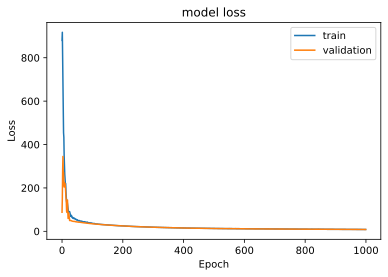

In [15]:
plot_loss(history1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


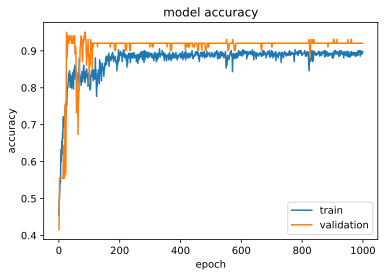

In [16]:
plot_hist(history1)

In [17]:
# evaluate the model
train_loss, train_acc = model.evaluate([X_img_train, X_audio_train], y_train, verbose=0)
test_loss, test_acc = model.evaluate([X_img_test, X_audio_test], y_test, verbose=0)
print('Train_Loss: %.3f, Train_Acc: %.3f' % (train_loss, train_acc))
print('Test_Loss: %.3f, Test_Acc: %.3f' % (test_loss, test_acc))

Train_Loss: 8.407, Train_Acc: 0.893
Test_Loss: 8.349, Test_Acc: 0.921


In [18]:
pred = model.predict([X_img_test, X_audio_test])

In [19]:
y_pred = (model.predict([X_img_test, X_audio_test]) > 0.5)*1    #.astype("int32")

In [20]:
#y_pred = np.zeros(pred.shape)
#y_pred[pred>0.5]=1
#y_pred = np.array(y_pred)

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
score = accuracy_score(y_test, y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
print("score:", score)
print("Precision:", precision)
print("Recall:", recall)
print("F1_score:", f1)

score: 0.9207920792079208
Precision: 0.8490566037735849
Recall: 1.0
F1_score: 0.9183673469387755


In [22]:
# confusion matrix
matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
print('Confusion matrix : \n',matrix)


Confusion matrix : 
 [[48  8]
 [ 0 45]]


In [23]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test, y_pred, labels=[0,1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       1.00      0.86      0.92        56
           1       0.85      1.00      0.92        45

    accuracy                           0.92       101
   macro avg       0.92      0.93      0.92       101
weighted avg       0.93      0.92      0.92       101



In [24]:
# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(y_test, y_pred,labels=[0,1]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

Outcome values : 
 48 8 0 45


In [25]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, concatenate
from keras.models import Model
import numpy as np
from keras import regularizers
from keras.layers import Dropout 
def compile_model():
    img_input = Input(shape=(50177,)) 
    ## branch 1 with image input
    x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(img_input)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    out_a = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    out_a = Dense(1, activation='sigmoid')(out_a)
    model = Model(img_input, out_a)
    adam = Adam(lr=0.001, decay=1e-5)
    print(model.summary())
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])
    return model
    #x = MaxPooling2D((2, 2))(x)
    #x = Flatten()(x)
    #out_a = Dense(64)(x)

    

In [26]:
model = compile_model()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50177)]           0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              51382272  
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0   

In [27]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
history_vis=model.fit(X_img_train, y_img_train, batch_size=256, epochs=1000,
                            validation_data=(X_img_test, y_img_test), callbacks=[es])

Epoch 1/1000
2/2 [==============================] - 3s 673ms/step - loss: 325.5758 - accuracy: 0.4938 - val_loss: 575.8466 - val_accuracy: 0.4455
Epoch 2/1000
2/2 [==============================] - 1s 467ms/step - loss: 715.2316 - accuracy: 0.5285 - val_loss: 166.9250 - val_accuracy: 0.4455
Epoch 3/1000
2/2 [==============================] - 1s 432ms/step - loss: 894.0620 - accuracy: 0.5062 - val_loss: 256.2506 - val_accuracy: 0.4455
Epoch 4/1000
2/2 [==============================] - 1s 407ms/step - loss: 661.0443 - accuracy: 0.5533 - val_loss: 226.3689 - val_accuracy: 0.4455
Epoch 5/1000
2/2 [==============================] - 1s 410ms/step - loss: 868.8257 - accuracy: 0.5186 - val_loss: 95.7448 - val_accuracy: 0.5545
Epoch 6/1000
2/2 [==============================] - 1s 426ms/step - loss: 704.0345 - accuracy: 0.4913 - val_loss: 81.5522 - val_accuracy: 0.4455
Epoch 7/1000
2/2 [==============================] - 1s 399ms/step - loss: 598.5201 - accuracy: 0.5236 - val_loss: 46.8277 - va

2/2 [==============================] - 1s 464ms/step - loss: 44.1407 - accuracy: 0.4913 - val_loss: 33.7631 - val_accuracy: 0.5941
Epoch 58/1000
2/2 [==============================] - 1s 436ms/step - loss: 43.6549 - accuracy: 0.4814 - val_loss: 33.6382 - val_accuracy: 0.5149
Epoch 59/1000
2/2 [==============================] - 1s 446ms/step - loss: 43.2737 - accuracy: 0.5335 - val_loss: 33.4809 - val_accuracy: 0.4653
Epoch 60/1000
2/2 [==============================] - 1s 429ms/step - loss: 44.0448 - accuracy: 0.4665 - val_loss: 33.3210 - val_accuracy: 0.4257
Epoch 61/1000
2/2 [==============================] - 1s 423ms/step - loss: 42.9561 - accuracy: 0.5186 - val_loss: 33.1426 - val_accuracy: 0.5545
Epoch 62/1000
2/2 [==============================] - 1s 512ms/step - loss: 40.5207 - accuracy: 0.5211 - val_loss: 33.0056 - val_accuracy: 0.5446
Epoch 63/1000
2/2 [==============================] - 1s 443ms/step - loss: 40.0243 - accuracy: 0.5285 - val_loss: 32.8326 - val_accuracy: 0.5446

2/2 [==============================] - 1s 430ms/step - loss: 28.5472 - accuracy: 0.5509 - val_loss: 26.7343 - val_accuracy: 0.4851
Epoch 114/1000
2/2 [==============================] - 1s 416ms/step - loss: 28.4173 - accuracy: 0.5310 - val_loss: 26.6375 - val_accuracy: 0.4653
Epoch 115/1000
2/2 [==============================] - 1s 432ms/step - loss: 28.5514 - accuracy: 0.4988 - val_loss: 26.5439 - val_accuracy: 0.5347
Epoch 116/1000
2/2 [==============================] - 1s 445ms/step - loss: 28.7959 - accuracy: 0.5012 - val_loss: 26.4555 - val_accuracy: 0.4950
Epoch 117/1000
2/2 [==============================] - 1s 446ms/step - loss: 28.6399 - accuracy: 0.5087 - val_loss: 26.3629 - val_accuracy: 0.5446
Epoch 118/1000
2/2 [==============================] - 1s 429ms/step - loss: 28.4344 - accuracy: 0.5583 - val_loss: 26.2700 - val_accuracy: 0.5545
Epoch 119/1000
2/2 [==============================] - 1s 430ms/step - loss: 28.0828 - accuracy: 0.5136 - val_loss: 26.1781 - val_accuracy: 

2/2 [==============================] - 1s 491ms/step - loss: 21.6842 - accuracy: 0.5360 - val_loss: 21.6180 - val_accuracy: 0.5545
Epoch 170/1000
2/2 [==============================] - 1s 398ms/step - loss: 21.6072 - accuracy: 0.5385 - val_loss: 21.5387 - val_accuracy: 0.5545
Epoch 171/1000
2/2 [==============================] - 1s 428ms/step - loss: 21.5265 - accuracy: 0.5409 - val_loss: 21.4582 - val_accuracy: 0.5545
Epoch 172/1000
2/2 [==============================] - 1s 430ms/step - loss: 21.4724 - accuracy: 0.5360 - val_loss: 21.3774 - val_accuracy: 0.5545
Epoch 173/1000
2/2 [==============================] - 1s 497ms/step - loss: 21.3721 - accuracy: 0.5335 - val_loss: 21.2990 - val_accuracy: 0.5545
Epoch 174/1000
2/2 [==============================] - 1s 441ms/step - loss: 21.2895 - accuracy: 0.5335 - val_loss: 21.2231 - val_accuracy: 0.5545
Epoch 175/1000
2/2 [==============================] - 1s 482ms/step - loss: 21.2105 - accuracy: 0.5385 - val_loss: 21.1484 - val_accuracy: 

2/2 [==============================] - 1s 503ms/step - loss: 17.9788 - accuracy: 0.5335 - val_loss: 17.9306 - val_accuracy: 0.5545
Epoch 226/1000
2/2 [==============================] - 1s 517ms/step - loss: 17.9334 - accuracy: 0.5360 - val_loss: 17.8744 - val_accuracy: 0.5545
Epoch 227/1000
2/2 [==============================] - 1s 481ms/step - loss: 17.8670 - accuracy: 0.5335 - val_loss: 17.8177 - val_accuracy: 0.5545
Epoch 228/1000
2/2 [==============================] - 1s 408ms/step - loss: 17.8119 - accuracy: 0.5335 - val_loss: 17.7640 - val_accuracy: 0.5545
Epoch 229/1000
2/2 [==============================] - 1s 442ms/step - loss: 17.7765 - accuracy: 0.5136 - val_loss: 17.7068 - val_accuracy: 0.5545
Epoch 230/1000
2/2 [==============================] - 1s 439ms/step - loss: 17.7009 - accuracy: 0.5360 - val_loss: 17.6578 - val_accuracy: 0.5545
Epoch 231/1000
2/2 [==============================] - 1s 428ms/step - loss: 17.6508 - accuracy: 0.5360 - val_loss: 17.6106 - val_accuracy: 

2/2 [==============================] - 1s 486ms/step - loss: 15.3009 - accuracy: 0.5385 - val_loss: 15.2614 - val_accuracy: 0.5545
Epoch 282/1000
2/2 [==============================] - 1s 428ms/step - loss: 15.2563 - accuracy: 0.5335 - val_loss: 15.2164 - val_accuracy: 0.5545
Epoch 283/1000
2/2 [==============================] - 1s 419ms/step - loss: 15.2118 - accuracy: 0.5335 - val_loss: 15.1707 - val_accuracy: 0.5545
Epoch 284/1000
2/2 [==============================] - 1s 415ms/step - loss: 15.1680 - accuracy: 0.5335 - val_loss: 15.1268 - val_accuracy: 0.5545
Epoch 285/1000
2/2 [==============================] - 1s 427ms/step - loss: 15.1214 - accuracy: 0.5360 - val_loss: 15.0825 - val_accuracy: 0.5545
Epoch 286/1000
2/2 [==============================] - 1s 404ms/step - loss: 15.0770 - accuracy: 0.5360 - val_loss: 15.0393 - val_accuracy: 0.5545
Epoch 287/1000
2/2 [==============================] - 1s 436ms/step - loss: 15.0429 - accuracy: 0.5236 - val_loss: 14.9955 - val_accuracy: 

2/2 [==============================] - 1s 455ms/step - loss: 13.3820 - accuracy: 0.5360 - val_loss: 13.3659 - val_accuracy: 0.5545
Epoch 338/1000
2/2 [==============================] - 1s 470ms/step - loss: 13.3654 - accuracy: 0.5360 - val_loss: 13.3498 - val_accuracy: 0.5545
Epoch 339/1000
2/2 [==============================] - 1s 494ms/step - loss: 13.3483 - accuracy: 0.5360 - val_loss: 13.3299 - val_accuracy: 0.5545
Epoch 340/1000
2/2 [==============================] - 1s 460ms/step - loss: 13.3319 - accuracy: 0.5211 - val_loss: 13.3067 - val_accuracy: 0.5545
Epoch 341/1000
2/2 [==============================] - 1s 402ms/step - loss: 13.4347 - accuracy: 0.5409 - val_loss: 13.2803 - val_accuracy: 0.5545
Epoch 342/1000
2/2 [==============================] - 1s 421ms/step - loss: 13.2794 - accuracy: 0.5335 - val_loss: 13.2563 - val_accuracy: 0.5545
Epoch 343/1000
2/2 [==============================] - 1s 421ms/step - loss: 13.2544 - accuracy: 0.5360 - val_loss: 13.2330 - val_accuracy: 

2/2 [==============================] - 1s 420ms/step - loss: 11.9833 - accuracy: 0.5360 - val_loss: 11.9594 - val_accuracy: 0.5545
Epoch 394/1000
2/2 [==============================] - 1s 490ms/step - loss: 11.9569 - accuracy: 0.5360 - val_loss: 11.9330 - val_accuracy: 0.5545
Epoch 395/1000
2/2 [==============================] - 1s 457ms/step - loss: 11.9305 - accuracy: 0.5360 - val_loss: 11.9056 - val_accuracy: 0.5545
Epoch 396/1000
2/2 [==============================] - 1s 470ms/step - loss: 11.9212 - accuracy: 0.5360 - val_loss: 11.8767 - val_accuracy: 0.5545
Epoch 397/1000
2/2 [==============================] - 1s 474ms/step - loss: 11.8738 - accuracy: 0.5360 - val_loss: 11.8470 - val_accuracy: 0.5545
Epoch 398/1000
2/2 [==============================] - 1s 507ms/step - loss: 11.8437 - accuracy: 0.5360 - val_loss: 11.8163 - val_accuracy: 0.5545
Epoch 399/1000
2/2 [==============================] - 1s 448ms/step - loss: 11.8131 - accuracy: 0.5360 - val_loss: 11.7848 - val_accuracy: 

2/2 [==============================] - 1s 468ms/step - loss: 10.8344 - accuracy: 0.5360 - val_loss: 10.8247 - val_accuracy: 0.5545
Epoch 450/1000
2/2 [==============================] - 1s 469ms/step - loss: 10.8253 - accuracy: 0.5360 - val_loss: 10.8154 - val_accuracy: 0.5545
Epoch 451/1000
2/2 [==============================] - 1s 445ms/step - loss: 10.8730 - accuracy: 0.5360 - val_loss: 10.8071 - val_accuracy: 0.5545
Epoch 452/1000
2/2 [==============================] - 1s 438ms/step - loss: 10.8088 - accuracy: 0.5360 - val_loss: 10.8028 - val_accuracy: 0.5545
Epoch 453/1000
2/2 [==============================] - 1s 491ms/step - loss: 10.8049 - accuracy: 0.5360 - val_loss: 10.7972 - val_accuracy: 0.5545
Epoch 454/1000
2/2 [==============================] - 1s 448ms/step - loss: 10.7986 - accuracy: 0.5360 - val_loss: 10.7901 - val_accuracy: 0.5545
Epoch 455/1000
2/2 [==============================] - 1s 525ms/step - loss: 10.7906 - accuracy: 0.5360 - val_loss: 10.7797 - val_accuracy: 

2/2 [==============================] - 1s 390ms/step - loss: 10.1063 - accuracy: 0.5335 - val_loss: 10.0905 - val_accuracy: 0.5545
Epoch 506/1000
2/2 [==============================] - 1s 448ms/step - loss: 10.0863 - accuracy: 0.5385 - val_loss: 10.0737 - val_accuracy: 0.5545
Epoch 507/1000
2/2 [==============================] - 1s 401ms/step - loss: 10.1077 - accuracy: 0.5112 - val_loss: 10.0553 - val_accuracy: 0.5545
Epoch 508/1000
2/2 [==============================] - 1s 427ms/step - loss: 10.0579 - accuracy: 0.5633 - val_loss: 10.0470 - val_accuracy: 0.5545
Epoch 509/1000
2/2 [==============================] - 1s 406ms/step - loss: 10.1921 - accuracy: 0.5186 - val_loss: 10.0583 - val_accuracy: 0.5545
Epoch 510/1000
2/2 [==============================] - 1s 434ms/step - loss: 10.0668 - accuracy: 0.5360 - val_loss: 10.0911 - val_accuracy: 0.5545
Epoch 511/1000
2/2 [==============================] - 1s 478ms/step - loss: 10.0999 - accuracy: 0.5385 - val_loss: 10.1275 - val_accuracy: 

Epoch 562/1000
2/2 [==============================] - 1s 452ms/step - loss: 9.5248 - accuracy: 0.5360 - val_loss: 9.5145 - val_accuracy: 0.5545
Epoch 563/1000
2/2 [==============================] - 1s 466ms/step - loss: 9.5158 - accuracy: 0.5360 - val_loss: 9.5035 - val_accuracy: 0.5545
Epoch 564/1000
2/2 [==============================] - 1s 485ms/step - loss: 9.5039 - accuracy: 0.5360 - val_loss: 9.4907 - val_accuracy: 0.5545
Epoch 565/1000
2/2 [==============================] - 1s 408ms/step - loss: 9.4907 - accuracy: 0.5360 - val_loss: 9.4762 - val_accuracy: 0.5545
Epoch 566/1000
2/2 [==============================] - 1s 462ms/step - loss: 9.4760 - accuracy: 0.5360 - val_loss: 9.4604 - val_accuracy: 0.5545
Epoch 567/1000
2/2 [==============================] - 1s 403ms/step - loss: 9.4600 - accuracy: 0.5360 - val_loss: 9.4435 - val_accuracy: 0.5545
Epoch 568/1000
2/2 [==============================] - 1s 422ms/step - loss: 9.4434 - accuracy: 0.5360 - val_loss: 9.4264 - val_accuracy:

Epoch 619/1000
2/2 [==============================] - 1s 394ms/step - loss: 9.0264 - accuracy: 0.5360 - val_loss: 9.0118 - val_accuracy: 0.5545
Epoch 620/1000
2/2 [==============================] - 1s 422ms/step - loss: 9.0156 - accuracy: 0.5533 - val_loss: 8.9984 - val_accuracy: 0.5545
Epoch 621/1000
2/2 [==============================] - 1s 421ms/step - loss: 8.9985 - accuracy: 0.5310 - val_loss: 8.9883 - val_accuracy: 0.5545
Epoch 622/1000
2/2 [==============================] - 1s 428ms/step - loss: 9.0049 - accuracy: 0.5360 - val_loss: 8.9787 - val_accuracy: 0.5545
Epoch 623/1000
2/2 [==============================] - 1s 449ms/step - loss: 8.9805 - accuracy: 0.5360 - val_loss: 8.9744 - val_accuracy: 0.5545
Epoch 624/1000
2/2 [==============================] - 1s 442ms/step - loss: 8.9767 - accuracy: 0.5360 - val_loss: 8.9725 - val_accuracy: 0.5545
Epoch 625/1000
2/2 [==============================] - 1s 433ms/step - loss: 8.9749 - accuracy: 0.5360 - val_loss: 8.9708 - val_accuracy:

Epoch 676/1000
2/2 [==============================] - 1s 379ms/step - loss: 8.7645 - accuracy: 0.5360 - val_loss: 8.7528 - val_accuracy: 0.5545
Epoch 677/1000
2/2 [==============================] - 1s 425ms/step - loss: 8.7534 - accuracy: 0.5360 - val_loss: 8.7396 - val_accuracy: 0.5545
Epoch 678/1000
2/2 [==============================] - 1s 455ms/step - loss: 8.7397 - accuracy: 0.5360 - val_loss: 8.7269 - val_accuracy: 0.5545
Epoch 679/1000
2/2 [==============================] - 1s 405ms/step - loss: 8.8080 - accuracy: 0.5335 - val_loss: 8.7128 - val_accuracy: 0.5545
Epoch 680/1000
2/2 [==============================] - 1s 378ms/step - loss: 8.7145 - accuracy: 0.5360 - val_loss: 8.7087 - val_accuracy: 0.5545
Epoch 681/1000
2/2 [==============================] - 1s 398ms/step - loss: 8.7281 - accuracy: 0.5409 - val_loss: 8.7055 - val_accuracy: 0.5545
Epoch 682/1000
2/2 [==============================] - 1s 365ms/step - loss: 8.7078 - accuracy: 0.5385 - val_loss: 8.7060 - val_accuracy:

Epoch 733/1000
2/2 [==============================] - 1s 463ms/step - loss: 8.4150 - accuracy: 0.5360 - val_loss: 8.4115 - val_accuracy: 0.5545
Epoch 734/1000
2/2 [==============================] - 1s 449ms/step - loss: 8.4200 - accuracy: 0.5434 - val_loss: 8.4081 - val_accuracy: 0.5545
Epoch 735/1000
2/2 [==============================] - 1s 489ms/step - loss: 8.4134 - accuracy: 0.5335 - val_loss: 8.4072 - val_accuracy: 0.5545
Epoch 736/1000
2/2 [==============================] - 1s 447ms/step - loss: 8.4097 - accuracy: 0.5360 - val_loss: 8.4067 - val_accuracy: 0.5545
Epoch 737/1000
2/2 [==============================] - 1s 447ms/step - loss: 8.4090 - accuracy: 0.5360 - val_loss: 8.4049 - val_accuracy: 0.5545
Epoch 738/1000
2/2 [==============================] - 1s 415ms/step - loss: 8.4069 - accuracy: 0.5360 - val_loss: 8.4010 - val_accuracy: 0.5545
Epoch 739/1000
2/2 [==============================] - 1s 404ms/step - loss: 8.4026 - accuracy: 0.5360 - val_loss: 8.3950 - val_accuracy:

Epoch 790/1000
2/2 [==============================] - 1s 377ms/step - loss: 8.2187 - accuracy: 0.5335 - val_loss: 8.2319 - val_accuracy: 0.5545
Epoch 791/1000
2/2 [==============================] - 1s 449ms/step - loss: 8.2440 - accuracy: 0.5136 - val_loss: 8.2536 - val_accuracy: 0.5545
Epoch 792/1000
2/2 [==============================] - 1s 417ms/step - loss: 8.2650 - accuracy: 0.5335 - val_loss: 8.2843 - val_accuracy: 0.5545
Epoch 793/1000
2/2 [==============================] - 1s 415ms/step - loss: 8.2909 - accuracy: 0.5310 - val_loss: 8.3130 - val_accuracy: 0.5545
Epoch 794/1000
2/2 [==============================] - 1s 439ms/step - loss: 8.3255 - accuracy: 0.5459 - val_loss: 8.3298 - val_accuracy: 0.5545
Epoch 795/1000
2/2 [==============================] - 1s 395ms/step - loss: 8.3365 - accuracy: 0.5335 - val_loss: 8.3405 - val_accuracy: 0.5545
Epoch 796/1000
2/2 [==============================] - 1s 457ms/step - loss: 8.3442 - accuracy: 0.5360 - val_loss: 8.3432 - val_accuracy:

Epoch 847/1000
2/2 [==============================] - 1s 420ms/step - loss: 8.0960 - accuracy: 0.5360 - val_loss: 8.0840 - val_accuracy: 0.5545
Epoch 848/1000
2/2 [==============================] - 1s 449ms/step - loss: 8.0845 - accuracy: 0.5360 - val_loss: 8.0716 - val_accuracy: 0.5545
Epoch 849/1000
2/2 [==============================] - 1s 461ms/step - loss: 8.0719 - accuracy: 0.5360 - val_loss: 8.0584 - val_accuracy: 0.5545
Epoch 850/1000
2/2 [==============================] - 1s 436ms/step - loss: 8.0586 - accuracy: 0.5360 - val_loss: 8.0445 - val_accuracy: 0.5545
Epoch 851/1000
2/2 [==============================] - 1s 451ms/step - loss: 8.0546 - accuracy: 0.5310 - val_loss: 8.0358 - val_accuracy: 0.5545
Epoch 852/1000
2/2 [==============================] - 1s 451ms/step - loss: 8.0642 - accuracy: 0.5186 - val_loss: 8.0359 - val_accuracy: 0.5545
Epoch 853/1000
2/2 [==============================] - 1s 459ms/step - loss: 8.0399 - accuracy: 0.5360 - val_loss: 8.0422 - val_accuracy:

Epoch 904/1000
2/2 [==============================] - 1s 365ms/step - loss: 7.9090 - accuracy: 0.5409 - val_loss: 7.9191 - val_accuracy: 0.5545
Epoch 905/1000
2/2 [==============================] - 1s 363ms/step - loss: 7.9243 - accuracy: 0.5409 - val_loss: 7.9330 - val_accuracy: 0.5545
Epoch 906/1000
2/2 [==============================] - 1s 399ms/step - loss: 7.9380 - accuracy: 0.5360 - val_loss: 7.9421 - val_accuracy: 0.5545
Epoch 907/1000
2/2 [==============================] - 1s 386ms/step - loss: 7.9458 - accuracy: 0.5360 - val_loss: 7.9462 - val_accuracy: 0.5545
Epoch 908/1000
2/2 [==============================] - 1s 441ms/step - loss: 7.9544 - accuracy: 0.5335 - val_loss: 7.9501 - val_accuracy: 0.5545
Epoch 909/1000
2/2 [==============================] - 1s 425ms/step - loss: 7.9532 - accuracy: 0.5360 - val_loss: 7.9512 - val_accuracy: 0.5545
Epoch 910/1000
2/2 [==============================] - 1s 475ms/step - loss: 7.9538 - accuracy: 0.5360 - val_loss: 7.9490 - val_accuracy:

Epoch 961/1000
2/2 [==============================] - 1s 434ms/step - loss: 7.7160 - accuracy: 0.5409 - val_loss: 7.6996 - val_accuracy: 0.5545
Epoch 962/1000
2/2 [==============================] - 1s 421ms/step - loss: 7.7578 - accuracy: 0.5434 - val_loss: 7.7049 - val_accuracy: 0.5545
Epoch 963/1000
2/2 [==============================] - 1s 379ms/step - loss: 7.7677 - accuracy: 0.5012 - val_loss: 7.7210 - val_accuracy: 0.5545
Epoch 964/1000
2/2 [==============================] - 1s 441ms/step - loss: 7.7392 - accuracy: 0.5335 - val_loss: 7.7483 - val_accuracy: 0.5545
Epoch 965/1000
2/2 [==============================] - 1s 392ms/step - loss: 7.7596 - accuracy: 0.5459 - val_loss: 7.7802 - val_accuracy: 0.5545
Epoch 966/1000
2/2 [==============================] - 1s 456ms/step - loss: 7.7884 - accuracy: 0.5385 - val_loss: 7.8073 - val_accuracy: 0.5545
Epoch 967/1000
2/2 [==============================] - 1s 444ms/step - loss: 7.8283 - accuracy: 0.5211 - val_loss: 7.8245 - val_accuracy:

In [28]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="lower right")
    plt.savefig('visual_acc.eps', format='eps')
    plt.show()

In [29]:
def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.savefig('visual_loss.eps', format='eps')
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


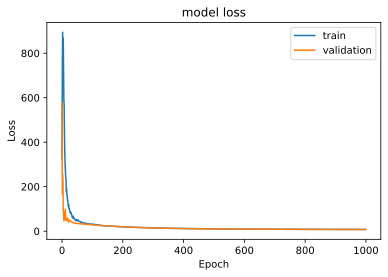

In [30]:
plot_loss(history_vis)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


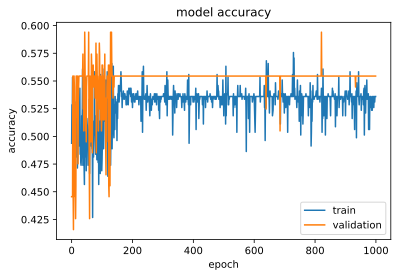

In [31]:
plot_hist(history_vis)

In [32]:
# evaluate the model
train_loss, train_acc = model.evaluate(X_img_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_img_test, y_test, verbose=0)
print('Train_Loss: %.3f, Train_Acc: %.3f' % (train_loss, train_acc))
print('Test_Loss: %.3f, Test_Acc: %.3f' % (test_loss, test_acc))

Train_Loss: 7.722, Train_Acc: 0.536
Test_Loss: 7.719, Test_Acc: 0.554


In [33]:
pred = model.predict(X_img_test)

In [34]:
y_pred = (model.predict(X_img_test) > 0.5)*1    #.astype("int32")

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
score = accuracy_score(y_test, y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
print("score:", score)
print("Precision:", precision)
print("Recall:", recall)
print("F1_score:", f1)

score: 0.5544554455445545
Precision: 0.0
Recall: 0.0
F1_score: 0.0


In [36]:
# confusion matrix
matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
print('Confusion matrix : \n',matrix)


Confusion matrix : 
 [[56  0]
 [45  0]]


In [37]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test, y_pred, labels=[0,1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.55      1.00      0.71        56
           1       0.00      0.00      0.00        45

    accuracy                           0.55       101
   macro avg       0.28      0.50      0.36       101
weighted avg       0.31      0.55      0.40       101



In [38]:
# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(y_test, y_pred,labels=[0,1]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

Outcome values : 
 56 0 45 0


In [39]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, concatenate
from keras.models import Model
import numpy as np
from keras import regularizers
from keras.layers import Dropout 
def compile_model():
    num_input = Input(shape=(133,))        ## branch 2 with numerical input
    x1 = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(num_input)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)
    x1 = Dropout(0.3)(x1)
    out_b = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)
    out_b = Dense(1, activation='sigmoid')(out_b)
    model = Model(num_input, out_b)
    adam = Adam(lr=0.001, decay=1e-5)
    print(model.summary())
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])
    return model

In [40]:
model = compile_model()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 133)]             0         
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              137216    
_________________________________________________________________
dropout_15 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0   

In [41]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
history_aud=model.fit(X_audio_train, y_audio_train, batch_size=256, epochs=1000,
                            validation_data=(X_audio_test, y_audio_test), callbacks=[es])

Epoch 1/1000
2/2 [==============================] - 1s 258ms/step - loss: 49.9484 - accuracy: 0.5161 - val_loss: 15.7826 - val_accuracy: 0.6931
Epoch 2/1000
2/2 [==============================] - 0s 49ms/step - loss: 31.9706 - accuracy: 0.4913 - val_loss: 28.1910 - val_accuracy: 0.5050
Epoch 3/1000
2/2 [==============================] - 0s 42ms/step - loss: 32.2076 - accuracy: 0.4814 - val_loss: 21.6062 - val_accuracy: 0.5050
Epoch 4/1000
2/2 [==============================] - 0s 43ms/step - loss: 28.4339 - accuracy: 0.4814 - val_loss: 15.0946 - val_accuracy: 0.4950
Epoch 5/1000
2/2 [==============================] - 0s 39ms/step - loss: 27.0813 - accuracy: 0.4938 - val_loss: 14.0336 - val_accuracy: 0.6535
Epoch 6/1000
2/2 [==============================] - 0s 41ms/step - loss: 25.6176 - accuracy: 0.4566 - val_loss: 13.4804 - val_accuracy: 0.9208
Epoch 7/1000
2/2 [==============================] - 0s 49ms/step - loss: 23.8141 - accuracy: 0.4715 - val_loss: 14.9689 - val_accuracy: 0.505

2/2 [==============================] - 0s 47ms/step - loss: 9.0360 - accuracy: 0.6203 - val_loss: 8.8435 - val_accuracy: 0.9109
Epoch 59/1000
2/2 [==============================] - 0s 72ms/step - loss: 8.9087 - accuracy: 0.6427 - val_loss: 8.7842 - val_accuracy: 0.8416
Epoch 60/1000
2/2 [==============================] - 0s 41ms/step - loss: 8.9140 - accuracy: 0.6452 - val_loss: 8.7467 - val_accuracy: 0.8416
Epoch 61/1000
2/2 [==============================] - 0s 45ms/step - loss: 8.8888 - accuracy: 0.6799 - val_loss: 8.6730 - val_accuracy: 0.9802
Epoch 62/1000
2/2 [==============================] - 0s 47ms/step - loss: 8.8918 - accuracy: 0.6328 - val_loss: 8.6149 - val_accuracy: 0.9802
Epoch 63/1000
2/2 [==============================] - 0s 66ms/step - loss: 8.7391 - accuracy: 0.7146 - val_loss: 8.5641 - val_accuracy: 0.9802
Epoch 64/1000
2/2 [==============================] - 0s 48ms/step - loss: 8.8209 - accuracy: 0.6849 - val_loss: 8.5043 - val_accuracy: 0.9703
Epoch 65/1000
2/2 [=

Epoch 116/1000
2/2 [==============================] - 0s 38ms/step - loss: 7.1710 - accuracy: 0.9404 - val_loss: 7.0443 - val_accuracy: 0.9901
Epoch 117/1000
2/2 [==============================] - 0s 43ms/step - loss: 7.1377 - accuracy: 0.9404 - val_loss: 7.0248 - val_accuracy: 0.9901
Epoch 118/1000
2/2 [==============================] - 0s 45ms/step - loss: 7.1280 - accuracy: 0.9578 - val_loss: 7.0059 - val_accuracy: 0.9901
Epoch 119/1000
2/2 [==============================] - 0s 60ms/step - loss: 7.0793 - accuracy: 0.9653 - val_loss: 6.9877 - val_accuracy: 0.9901
Epoch 120/1000
2/2 [==============================] - 0s 50ms/step - loss: 7.0624 - accuracy: 0.9653 - val_loss: 6.9777 - val_accuracy: 0.9802
Epoch 121/1000
2/2 [==============================] - 0s 48ms/step - loss: 7.0498 - accuracy: 0.9553 - val_loss: 6.9679 - val_accuracy: 0.9802
Epoch 122/1000
2/2 [==============================] - 0s 41ms/step - loss: 7.0747 - accuracy: 0.9529 - val_loss: 6.9253 - val_accuracy: 0.9901

2/2 [==============================] - 0s 40ms/step - loss: 6.0917 - accuracy: 0.9578 - val_loss: 6.0108 - val_accuracy: 0.9901
Epoch 174/1000
2/2 [==============================] - 0s 40ms/step - loss: 6.0549 - accuracy: 0.9851 - val_loss: 5.9986 - val_accuracy: 0.9901
Epoch 175/1000
2/2 [==============================] - 0s 47ms/step - loss: 6.0464 - accuracy: 0.9727 - val_loss: 5.9961 - val_accuracy: 0.9901
Epoch 176/1000
2/2 [==============================] - 0s 39ms/step - loss: 6.0172 - accuracy: 0.9777 - val_loss: 5.9989 - val_accuracy: 0.9802
Epoch 177/1000
2/2 [==============================] - 0s 46ms/step - loss: 5.9905 - accuracy: 0.9826 - val_loss: 5.9797 - val_accuracy: 0.9802
Epoch 178/1000
2/2 [==============================] - 0s 44ms/step - loss: 6.0092 - accuracy: 0.9702 - val_loss: 5.9487 - val_accuracy: 0.9901
Epoch 179/1000
2/2 [==============================] - 0s 41ms/step - loss: 5.9695 - accuracy: 0.9727 - val_loss: 5.9244 - val_accuracy: 0.9901
Epoch 180/1000

2/2 [==============================] - 0s 42ms/step - loss: 5.2071 - accuracy: 0.9777 - val_loss: 5.1674 - val_accuracy: 0.9901
Epoch 231/1000
2/2 [==============================] - 0s 44ms/step - loss: 5.1799 - accuracy: 0.9801 - val_loss: 5.1454 - val_accuracy: 0.9901
Epoch 232/1000
2/2 [==============================] - 0s 41ms/step - loss: 5.1602 - accuracy: 0.9801 - val_loss: 5.1274 - val_accuracy: 0.9901
Epoch 233/1000
2/2 [==============================] - 0s 40ms/step - loss: 5.1430 - accuracy: 0.9801 - val_loss: 5.1127 - val_accuracy: 0.9901
Epoch 234/1000
2/2 [==============================] - 0s 47ms/step - loss: 5.1373 - accuracy: 0.9777 - val_loss: 5.1038 - val_accuracy: 0.9901
Epoch 235/1000
2/2 [==============================] - 0s 39ms/step - loss: 5.1211 - accuracy: 0.9826 - val_loss: 5.0799 - val_accuracy: 0.9901
Epoch 236/1000
2/2 [==============================] - 0s 44ms/step - loss: 5.0987 - accuracy: 0.9876 - val_loss: 5.0640 - val_accuracy: 0.9901
Epoch 237/1000

2/2 [==============================] - 0s 44ms/step - loss: 4.4602 - accuracy: 0.9801 - val_loss: 4.4148 - val_accuracy: 0.9901
Epoch 288/1000
2/2 [==============================] - 0s 54ms/step - loss: 4.4350 - accuracy: 0.9876 - val_loss: 4.4113 - val_accuracy: 0.9901
Epoch 289/1000
2/2 [==============================] - 0s 50ms/step - loss: 4.4124 - accuracy: 0.9851 - val_loss: 4.4154 - val_accuracy: 0.9802
Epoch 290/1000
2/2 [==============================] - 0s 61ms/step - loss: 4.3901 - accuracy: 0.9901 - val_loss: 4.4171 - val_accuracy: 0.9802
Epoch 291/1000
2/2 [==============================] - 0s 43ms/step - loss: 4.4303 - accuracy: 0.9727 - val_loss: 4.3845 - val_accuracy: 0.9901
Epoch 292/1000
2/2 [==============================] - 0s 42ms/step - loss: 4.3784 - accuracy: 0.9876 - val_loss: 4.3677 - val_accuracy: 0.9901
Epoch 293/1000
2/2 [==============================] - 0s 83ms/step - loss: 4.3844 - accuracy: 0.9851 - val_loss: 4.3480 - val_accuracy: 0.9901
Epoch 294/1000

2/2 [==============================] - 0s 40ms/step - loss: 3.8402 - accuracy: 0.9727 - val_loss: 3.7844 - val_accuracy: 0.9901
Epoch 345/1000
2/2 [==============================] - 0s 47ms/step - loss: 3.8346 - accuracy: 0.9677 - val_loss: 3.7865 - val_accuracy: 0.9901
Epoch 346/1000
2/2 [==============================] - 0s 45ms/step - loss: 3.7935 - accuracy: 0.9826 - val_loss: 3.8106 - val_accuracy: 0.9802
Epoch 347/1000
2/2 [==============================] - 0s 56ms/step - loss: 3.7819 - accuracy: 0.9926 - val_loss: 3.8051 - val_accuracy: 0.9802
Epoch 348/1000
2/2 [==============================] - 0s 45ms/step - loss: 3.7989 - accuracy: 0.9752 - val_loss: 3.7610 - val_accuracy: 0.9901
Epoch 349/1000
2/2 [==============================] - 0s 48ms/step - loss: 3.7612 - accuracy: 0.9851 - val_loss: 3.7380 - val_accuracy: 0.9901
Epoch 350/1000
2/2 [==============================] - 0s 40ms/step - loss: 3.7480 - accuracy: 0.9826 - val_loss: 3.7254 - val_accuracy: 0.9802
Epoch 351/1000

2/2 [==============================] - 0s 49ms/step - loss: 3.2931 - accuracy: 0.9801 - val_loss: 3.2575 - val_accuracy: 0.9901
Epoch 402/1000
2/2 [==============================] - 0s 55ms/step - loss: 3.2727 - accuracy: 0.9926 - val_loss: 3.2530 - val_accuracy: 0.9901
Epoch 403/1000
2/2 [==============================] - 0s 40ms/step - loss: 3.2676 - accuracy: 0.9826 - val_loss: 3.2447 - val_accuracy: 0.9901
Epoch 404/1000
2/2 [==============================] - 0s 43ms/step - loss: 3.2500 - accuracy: 0.9826 - val_loss: 3.2287 - val_accuracy: 0.9901
Epoch 405/1000
2/2 [==============================] - 0s 40ms/step - loss: 3.2448 - accuracy: 0.9876 - val_loss: 3.2207 - val_accuracy: 0.9901
Epoch 406/1000
2/2 [==============================] - 0s 41ms/step - loss: 3.2219 - accuracy: 0.9926 - val_loss: 3.2199 - val_accuracy: 0.9901
Epoch 407/1000
2/2 [==============================] - 0s 45ms/step - loss: 3.2210 - accuracy: 0.9876 - val_loss: 3.2183 - val_accuracy: 0.9802
Epoch 408/1000

2/2 [==============================] - 0s 45ms/step - loss: 2.8225 - accuracy: 0.9901 - val_loss: 2.8011 - val_accuracy: 0.9901
Epoch 459/1000
2/2 [==============================] - 0s 49ms/step - loss: 2.8101 - accuracy: 0.9926 - val_loss: 2.8007 - val_accuracy: 0.9901
Epoch 460/1000
2/2 [==============================] - 0s 53ms/step - loss: 2.7942 - accuracy: 0.9851 - val_loss: 2.7990 - val_accuracy: 0.9901
Epoch 461/1000
2/2 [==============================] - 0s 54ms/step - loss: 2.7982 - accuracy: 0.9851 - val_loss: 2.7959 - val_accuracy: 0.9901
Epoch 462/1000
2/2 [==============================] - 0s 43ms/step - loss: 2.7758 - accuracy: 0.9851 - val_loss: 2.7863 - val_accuracy: 0.9901
Epoch 463/1000
2/2 [==============================] - 0s 49ms/step - loss: 2.7868 - accuracy: 0.9851 - val_loss: 2.7654 - val_accuracy: 0.9901
Epoch 464/1000
2/2 [==============================] - 0s 76ms/step - loss: 2.7871 - accuracy: 0.9801 - val_loss: 2.7524 - val_accuracy: 0.9901
Epoch 465/1000

2/2 [==============================] - 0s 45ms/step - loss: 2.4280 - accuracy: 0.9876 - val_loss: 2.4154 - val_accuracy: 0.9901
Epoch 516/1000
2/2 [==============================] - 0s 46ms/step - loss: 2.4138 - accuracy: 0.9851 - val_loss: 2.3872 - val_accuracy: 0.9802
Epoch 517/1000
2/2 [==============================] - 0s 53ms/step - loss: 2.4264 - accuracy: 0.9801 - val_loss: 2.3817 - val_accuracy: 0.9802
Epoch 518/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.4207 - accuracy: 0.9777 - val_loss: 2.3969 - val_accuracy: 0.9901
Epoch 519/1000
2/2 [==============================] - 0s 41ms/step - loss: 2.3913 - accuracy: 0.9901 - val_loss: 2.4204 - val_accuracy: 0.9802
Epoch 520/1000
2/2 [==============================] - 0s 47ms/step - loss: 2.4199 - accuracy: 0.9826 - val_loss: 2.4047 - val_accuracy: 0.9802
Epoch 521/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.4081 - accuracy: 0.9851 - val_loss: 2.3647 - val_accuracy: 0.9901
Epoch 522/1000

2/2 [==============================] - 0s 49ms/step - loss: 2.0757 - accuracy: 0.9826 - val_loss: 2.0662 - val_accuracy: 0.9901
Epoch 573/1000
2/2 [==============================] - 0s 40ms/step - loss: 2.0798 - accuracy: 0.9826 - val_loss: 2.0706 - val_accuracy: 0.9901
Epoch 574/1000
2/2 [==============================] - 0s 42ms/step - loss: 2.0609 - accuracy: 0.9926 - val_loss: 2.0795 - val_accuracy: 0.9901
Epoch 575/1000
2/2 [==============================] - 0s 42ms/step - loss: 2.0725 - accuracy: 0.9876 - val_loss: 2.0697 - val_accuracy: 0.9901
Epoch 576/1000
2/2 [==============================] - 0s 46ms/step - loss: 2.0609 - accuracy: 0.9926 - val_loss: 2.0519 - val_accuracy: 0.9901
Epoch 577/1000
2/2 [==============================] - 0s 42ms/step - loss: 2.0552 - accuracy: 0.9876 - val_loss: 2.0423 - val_accuracy: 0.9901
Epoch 578/1000
2/2 [==============================] - 0s 46ms/step - loss: 2.0364 - accuracy: 0.9901 - val_loss: 2.0360 - val_accuracy: 0.9901
Epoch 579/1000

2/2 [==============================] - 0s 52ms/step - loss: 1.7792 - accuracy: 0.9876 - val_loss: 1.7837 - val_accuracy: 0.9901
Epoch 630/1000
2/2 [==============================] - 0s 48ms/step - loss: 1.7804 - accuracy: 0.9876 - val_loss: 1.7727 - val_accuracy: 0.9901
Epoch 631/1000
2/2 [==============================] - 0s 46ms/step - loss: 1.7606 - accuracy: 0.9876 - val_loss: 1.7677 - val_accuracy: 0.9901
Epoch 632/1000
2/2 [==============================] - 0s 40ms/step - loss: 1.7551 - accuracy: 0.9950 - val_loss: 1.7638 - val_accuracy: 0.9901
Epoch 633/1000
2/2 [==============================] - 0s 43ms/step - loss: 1.7448 - accuracy: 0.9926 - val_loss: 1.7641 - val_accuracy: 0.9901
Epoch 634/1000
2/2 [==============================] - 0s 43ms/step - loss: 1.7614 - accuracy: 0.9901 - val_loss: 1.7408 - val_accuracy: 0.9901
Epoch 635/1000
2/2 [==============================] - 0s 45ms/step - loss: 1.7596 - accuracy: 0.9876 - val_loss: 1.7285 - val_accuracy: 0.9901
Epoch 636/1000

2/2 [==============================] - 0s 39ms/step - loss: 1.5311 - accuracy: 0.9876 - val_loss: 1.5268 - val_accuracy: 0.9901
Epoch 687/1000
2/2 [==============================] - 0s 67ms/step - loss: 1.5290 - accuracy: 0.9901 - val_loss: 1.5150 - val_accuracy: 0.9901
Epoch 688/1000
2/2 [==============================] - 0s 47ms/step - loss: 1.5295 - accuracy: 0.9851 - val_loss: 1.5098 - val_accuracy: 0.9901
Epoch 689/1000
2/2 [==============================] - 0s 51ms/step - loss: 1.5246 - accuracy: 0.9926 - val_loss: 1.5209 - val_accuracy: 0.9901
Epoch 690/1000
2/2 [==============================] - 0s 38ms/step - loss: 1.5208 - accuracy: 0.9901 - val_loss: 1.5331 - val_accuracy: 0.9802
Epoch 691/1000
2/2 [==============================] - 0s 42ms/step - loss: 1.5152 - accuracy: 0.9851 - val_loss: 1.5152 - val_accuracy: 0.9901
Epoch 692/1000
2/2 [==============================] - 0s 46ms/step - loss: 1.5110 - accuracy: 0.9926 - val_loss: 1.4925 - val_accuracy: 0.9901
Epoch 693/1000

2/2 [==============================] - 0s 49ms/step - loss: 1.3240 - accuracy: 0.9876 - val_loss: 1.3454 - val_accuracy: 0.9703
Epoch 744/1000
2/2 [==============================] - 0s 39ms/step - loss: 1.3775 - accuracy: 0.9553 - val_loss: 1.2936 - val_accuracy: 0.9901
Epoch 745/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.3044 - accuracy: 0.9926 - val_loss: 1.3468 - val_accuracy: 0.9802
Epoch 746/1000
2/2 [==============================] - 0s 48ms/step - loss: 1.3189 - accuracy: 0.9901 - val_loss: 1.3843 - val_accuracy: 0.9802
Epoch 747/1000
2/2 [==============================] - 0s 66ms/step - loss: 1.3394 - accuracy: 0.9876 - val_loss: 1.3180 - val_accuracy: 0.9901
Epoch 748/1000
2/2 [==============================] - 0s 38ms/step - loss: 1.3033 - accuracy: 0.9901 - val_loss: 1.2874 - val_accuracy: 0.9802
Epoch 749/1000
2/2 [==============================] - 0s 39ms/step - loss: 1.3110 - accuracy: 0.9876 - val_loss: 1.2896 - val_accuracy: 0.9802
Epoch 750/1000

2/2 [==============================] - 0s 44ms/step - loss: 1.1238 - accuracy: 0.9950 - val_loss: 1.1246 - val_accuracy: 0.9901
Epoch 801/1000
2/2 [==============================] - 0s 37ms/step - loss: 1.1206 - accuracy: 0.9901 - val_loss: 1.1279 - val_accuracy: 0.9901
Epoch 802/1000
2/2 [==============================] - 0s 43ms/step - loss: 1.1210 - accuracy: 0.9876 - val_loss: 1.1310 - val_accuracy: 0.9901
Epoch 803/1000
2/2 [==============================] - 0s 44ms/step - loss: 1.1276 - accuracy: 0.9876 - val_loss: 1.1294 - val_accuracy: 0.9901
Epoch 804/1000
2/2 [==============================] - 0s 44ms/step - loss: 1.1163 - accuracy: 0.9901 - val_loss: 1.1059 - val_accuracy: 0.9901
Epoch 805/1000
2/2 [==============================] - 0s 46ms/step - loss: 1.1222 - accuracy: 0.9901 - val_loss: 1.0995 - val_accuracy: 0.9901
Epoch 806/1000
2/2 [==============================] - 0s 46ms/step - loss: 1.0986 - accuracy: 0.9950 - val_loss: 1.1126 - val_accuracy: 0.9901
Epoch 807/1000

2/2 [==============================] - 0s 49ms/step - loss: 0.9721 - accuracy: 0.9926 - val_loss: 0.9650 - val_accuracy: 0.9901
Epoch 858/1000
2/2 [==============================] - 0s 47ms/step - loss: 0.9749 - accuracy: 0.9876 - val_loss: 0.9458 - val_accuracy: 1.0000
Epoch 859/1000
2/2 [==============================] - 0s 53ms/step - loss: 0.9627 - accuracy: 0.9950 - val_loss: 0.9441 - val_accuracy: 1.0000
Epoch 860/1000
2/2 [==============================] - 0s 69ms/step - loss: 0.9634 - accuracy: 0.9901 - val_loss: 0.9595 - val_accuracy: 0.9901
Epoch 861/1000
2/2 [==============================] - 0s 53ms/step - loss: 0.9577 - accuracy: 0.9926 - val_loss: 0.9774 - val_accuracy: 0.9901
Epoch 862/1000
2/2 [==============================] - 0s 43ms/step - loss: 0.9759 - accuracy: 0.9901 - val_loss: 0.9657 - val_accuracy: 0.9901
Epoch 863/1000
2/2 [==============================] - 0s 64ms/step - loss: 0.9502 - accuracy: 0.9950 - val_loss: 0.9504 - val_accuracy: 0.9901
Epoch 864/1000

2/2 [==============================] - 0s 38ms/step - loss: 0.8534 - accuracy: 0.9826 - val_loss: 0.8214 - val_accuracy: 0.9901
Epoch 915/1000
2/2 [==============================] - 0s 45ms/step - loss: 0.8335 - accuracy: 0.9901 - val_loss: 0.8388 - val_accuracy: 0.9901
Epoch 916/1000
2/2 [==============================] - 0s 39ms/step - loss: 0.8318 - accuracy: 0.9851 - val_loss: 0.8205 - val_accuracy: 0.9901
Epoch 917/1000
2/2 [==============================] - 0s 42ms/step - loss: 0.8236 - accuracy: 0.9926 - val_loss: 0.8117 - val_accuracy: 1.0000
Epoch 918/1000
2/2 [==============================] - 0s 43ms/step - loss: 0.8313 - accuracy: 0.9851 - val_loss: 0.8089 - val_accuracy: 1.0000
Epoch 919/1000
2/2 [==============================] - 0s 41ms/step - loss: 0.8203 - accuracy: 0.9926 - val_loss: 0.8163 - val_accuracy: 0.9901
Epoch 920/1000
2/2 [==============================] - 0s 52ms/step - loss: 0.8142 - accuracy: 0.9950 - val_loss: 0.8206 - val_accuracy: 0.9901
Epoch 921/1000

2/2 [==============================] - 0s 44ms/step - loss: 0.7238 - accuracy: 0.9926 - val_loss: 0.7011 - val_accuracy: 0.9901
Epoch 972/1000
2/2 [==============================] - 0s 43ms/step - loss: 0.7050 - accuracy: 0.9950 - val_loss: 0.6972 - val_accuracy: 0.9901
Epoch 973/1000
2/2 [==============================] - 0s 53ms/step - loss: 0.7087 - accuracy: 0.9950 - val_loss: 0.6955 - val_accuracy: 0.9901
Epoch 974/1000
2/2 [==============================] - 0s 40ms/step - loss: 0.7053 - accuracy: 0.9950 - val_loss: 0.6925 - val_accuracy: 0.9901
Epoch 975/1000
2/2 [==============================] - 0s 39ms/step - loss: 0.7073 - accuracy: 0.9950 - val_loss: 0.6876 - val_accuracy: 1.0000
Epoch 976/1000
2/2 [==============================] - 0s 51ms/step - loss: 0.7045 - accuracy: 0.9851 - val_loss: 0.6932 - val_accuracy: 0.9901
Epoch 977/1000
2/2 [==============================] - 0s 45ms/step - loss: 0.7075 - accuracy: 0.9901 - val_loss: 0.6905 - val_accuracy: 0.9901
Epoch 978/1000

In [42]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="lower right")
    plt.savefig('audio_acc.eps', format='eps')
    plt.show()

In [43]:
def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.savefig('audio_loss.eps', format='eps')
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


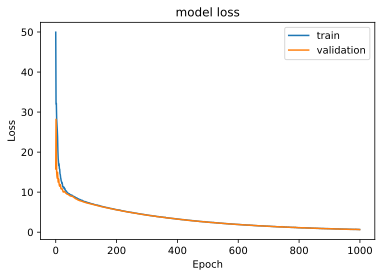

In [44]:
plot_loss(history_aud)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


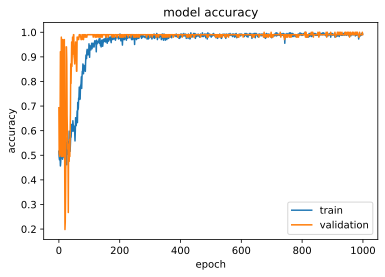

In [45]:
plot_hist(history_aud)

In [46]:
# evaluate the model
train_loss, train_acc = model.evaluate(X_audio_train, y_audio_train, verbose=0)
test_loss, test_acc = model.evaluate(X_audio_test, y_audio_test, verbose=0)
print('Train_Loss: %.3f, Train_Acc: %.3f' % (train_loss, train_acc))
print('Test_Loss: %.3f, Test_Acc: %.3f' % (test_loss, test_acc))

Train_Loss: 0.652, Train_Acc: 0.995
Test_Loss: 0.651, Test_Acc: 0.990


In [47]:
pred = model.predict(X_audio_test)

In [48]:
y_pred = (model.predict(X_audio_test) > 0.5)*1

In [49]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
score = accuracy_score(y_audio_test, y_pred)
precision = precision_score(y_audio_test,y_pred)
recall = recall_score(y_audio_test,y_pred)
f1 = f1_score(y_audio_test,y_pred)
print("score:", score)
print("Precision:", precision)
print("Recall:", recall)
print("F1_score:", f1)

score: 0.9900990099009901
Precision: 1.0
Recall: 0.98
F1_score: 0.98989898989899


In [50]:
# confusion matrix
matrix = confusion_matrix(y_audio_test, y_pred, labels=[0,1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[51  0]
 [ 1 49]]


In [51]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_audio_test, y_pred, labels=[0,1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        51
           1       1.00      0.98      0.99        50

    accuracy                           0.99       101
   macro avg       0.99      0.99      0.99       101
weighted avg       0.99      0.99      0.99       101



In [52]:
# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(y_audio_test, y_pred,labels=[0,1]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

Outcome values : 
 51 0 1 49


In [53]:
df1=pd.DataFrame(history1.history)
df1.to_csv('ours_MAV_net.csv')

In [54]:
df2=pd.DataFrame(history_aud.history)
df2.to_csv('ours_aud_net.csv')

In [55]:
df3=pd.DataFrame(history_vis.history)
df3.to_csv('ours_vis_net.csv')